![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from urllib import request
from skimage.segmentation import quickshift
from io import BytesIO
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
url1 = 'https://upload.wikimedia.org/wikipedia/commons/2/2b/Schloss-Erlangen02.JPG'
url2 = 'https://upload.wikimedia.org/wikipedia/commons/0/0c/Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG'
url3 = 'https://upload.wikimedia.org/wikipedia/commons/c/cc/Alte-universitaets-bibliothek_universitaet-erlangen.jpg'

In [ ]:
## Loading Data from URL
def get_image(url):
  load_url=request.urlopen(url)     #Load url data
  read_url_data=load_url.read()     # Reading data from loaded url
  make_array_from_data = np.frombuffer(read_url_data, dtype=np.uint8)
  picture = plt.imread(BytesIO(make_array_from_data), format='jpeg')

  return picture

image1 = get_image(url1)
image2 = get_image(url2)
image3 = get_image(url3)
img1 = cv2.resize(image1,(299,299))
img2 = cv2.resize(image2,(299,299))
img3 = cv2.resize(image3,(299,299))

In [ ]:
## Segment image
def segment_images(input_image):
  segment = quickshift(input_image, kernel_size=15, max_dist=23, ratio=0.7)
  return segment


In [ ]:
#Generate Superpxel

def generated_superpixels(input_image,input_segment):
  super_pixel = []
  uniq_val=np.unique(input_segment)
  for i in range(len(uniq_val)):
    mask = np.zeros_like(input_segment)
    mask[input_segment==i]=1
    masked_image= mask
    masked_image= np.stack((masked_image,masked_image,masked_image),axis = -1)
    current_super_pixel = masked_image*input_image
    super_pixel.append(current_super_pixel)
  return super_pixel


In [ ]:
#Generate Perturb image

def perturb_images(input_super_pixels):
  index = np.zeros((300,len(input_super_pixels)))
  all_perturbated_images = []
  for j in range(0,300):
    one_perturb_image =  np.zeros_like(input_super_pixels[1])
    for i in range(len(input_super_pixels)):
      super_pixel_image = input_super_pixels[i]
      zero_or_one = int(np.round(np.random.rand()))
      if zero_or_one == 1:
        index[j][i]=1
      random_super_pixel_on_off = super_pixel_image*zero_or_one
      one_perturb_image = one_perturb_image+random_super_pixel_on_off
    finalimage = one_perturb_image
    all_perturbated_images.append(finalimage)

  return all_perturbated_images,index



In [ ]:
#Load inception model

model = torchvision.models.inception_v3(pretrained=True)

C:\Users\Lalit Sharma\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lalit Sharma\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#Incetion output

def incep_v3_output(input_imgs):
  transform = transforms.Compose([ transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.float()),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

  img_tensor = transform(input_imgs)
  img_tensor = img_tensor.unsqueeze(0)
  model.eval()
  outputs = model(img_tensor)


  #Get probabilities of the image classes
  probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

  return probabilities


In [ ]:
#Top two probabilities

def get_top_two_probabilities(input_inception_output):
  top2 = np.sort(input_inception_output.detach().numpy())[ ::-1][:2]
  top2index =  np.argsort(input_inception_output.detach().numpy())[ ::-1][:2]
  return top2index

In [ ]:
#Get similarity score

def cosine_similarity_of_images(img,input_perturbated_images):
  vec1 = img.flatten()
  cosine_similariy_score = []
  for i in range(len(input_perturbated_images)):
    vec2 = input_perturbated_images[i].flatten()

    # calculate the cosine similarity between the two vectors
    cos_sim = cosine_similarity([vec1], [vec2])[0, 0]
    cosine_similariy_score.append(cos_sim)
  return cosine_similariy_score

In [ ]:
#Probability score of top 2 categories of images prediction

def get_score_of_top_two_probability_for_perturbated_images(input_perturbated_images,input_top_two_probability_index1):

  prob_1_store = []
  prob_2_store = []
  for i in range(0,len(input_perturbated_images)):
    pertubed_images_inception_output = incep_v3_output(input_perturbated_images[i])
    first_prob = pertubed_images_inception_output[(input_top_two_probability_index1[0])].detach().numpy()
    second_prob = pertubed_images_inception_output[(input_top_two_probability_index1[1])].detach().numpy()
    prob_1_store.append(first_prob)
    prob_2_store.append(second_prob)

  return prob_1_store,prob_2_store

In [ ]:
#Linear model training

def train_linear_model(input_xdata_index,input_ydata_prob_container,obtained_similarity_score):

  xdata = input_xdata_index
  ydata = input_ydata_prob_container

  lr_model = sklearn.linear_model.LinearRegression()
  lr_model.fit(xdata, ydata, sample_weight=obtained_similarity_score)
  cof = np.array(lr_model.coef_)
  top_cof = np.argsort(cof)[ ::-1][:2]
  return top_cof



In [ ]:
## For image 1

segment1 = segment_images(img1)
super_pixels1 = generated_superpixels(img1,segment1)
perturbated_images1,index1 = perturb_images(super_pixels1)
inception_output1 = incep_v3_output(img1)
top_two_probability_index1 = get_top_two_probabilities(inception_output1)
similarity_score1 = cosine_similarity_of_images(img1,perturbated_images1)
prob_1_container1,prob_2_container1 = get_score_of_top_two_probability_for_perturbated_images(perturbated_images1,top_two_probability_index1)



[]

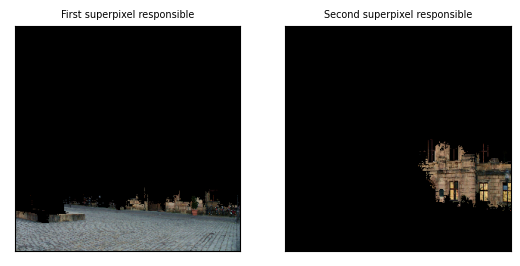

In [ ]:
# Image 1 first probability

images_top_cof1_1 = train_linear_model(index1,prob_1_container1,similarity_score1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(super_pixels1[(images_top_cof1_1[0])])
ax1.set_title('First superpixel responsible',fontsize=7)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(super_pixels1[(images_top_cof1_1[1])])
ax2.set_title('Second superpixel responsible',fontsize=7)
ax2.set_xticks([])
ax2.set_yticks([])

[]

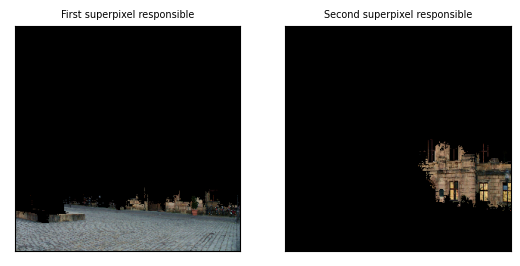

In [ ]:
# Image 1 Second Probability

images_top_cof1_2 = train_linear_model(index1,prob_2_container1,similarity_score1)
fig, (axi1, axi2) = plt.subplots(1, 2)
axi1.imshow(super_pixels1[(images_top_cof1_2[0])])
axi1.set_title('First superpixel responsible',fontsize=7)
axi1.set_xticks([])
axi1.set_yticks([])
axi2.imshow(super_pixels1[(images_top_cof1_2[1])])
axi2.set_title('Second superpixel responsible',fontsize=7)
axi2.set_xticks([])
axi2.set_yticks([])

In [ ]:
## For image 2

segment2 = segment_images(img2)
super_pixels2 = generated_superpixels(img2,segment2)
perturbated_images2,index2 = perturb_images(super_pixels2)
inception_output2 = incep_v3_output(img2)
top_two_probability_index2 = get_top_two_probabilities(inception_output2)
similarity_score2 = cosine_similarity_of_images(img2,perturbated_images2)
prob_1_container2,prob_2_container2 = get_score_of_top_two_probability_for_perturbated_images(perturbated_images2,top_two_probability_index2)


[]

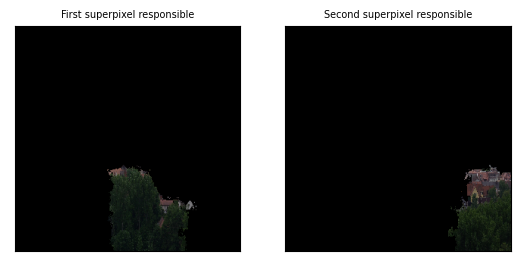

In [ ]:
# image 2 first probability

images_top_cof2_1 = train_linear_model(index2,prob_1_container2,similarity_score2)

fig, (ax2_1, ax2_2) = plt.subplots(1, 2)
ax2_1.imshow(super_pixels2[(images_top_cof2_1[0])])
ax2_1.set_title('First superpixel responsible',fontsize=7)
ax2_1.set_xticks([])
ax2_1.set_yticks([])
ax2_2.imshow(super_pixels2[(images_top_cof2_1[1])])
ax2_2.set_title('Second superpixel responsible',fontsize=7)
ax2_2.set_xticks([])
ax2_2.set_yticks([])

[]

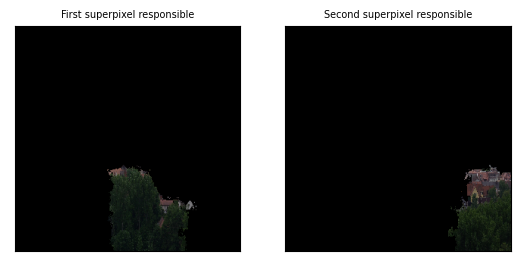

In [ ]:
# image 2 second probability

images_top_cof2_2 = train_linear_model(index2,prob_2_container2,similarity_score2)

fig, (axi1_2, axi2_2) = plt.subplots(1, 2)
axi1_2.imshow(super_pixels2[(images_top_cof2_2[0])])
axi1_2.set_title('First superpixel responsible',fontsize=7)
axi1_2.set_xticks([])
axi1_2.set_yticks([])
axi2_2.imshow(super_pixels2[(images_top_cof2_2[1])])
axi2_2.set_title('Second superpixel responsible',fontsize=7)
axi2_2.set_xticks([])
axi2_2.set_yticks([])

In [ ]:
## For image 3

segment3 = segment_images(img3)
super_pixels3 = generated_superpixels(img3,segment3)
perturbated_images3,index3 = perturb_images(super_pixels3)
inception_output3 = incep_v3_output(img3)
top_two_probability_index3 = get_top_two_probabilities(inception_output3)
similarity_score3 = cosine_similarity_of_images(img3,perturbated_images3)
prob_1_container3,prob_2_container3 = get_score_of_top_two_probability_for_perturbated_images(perturbated_images3,top_two_probability_index3)


[]

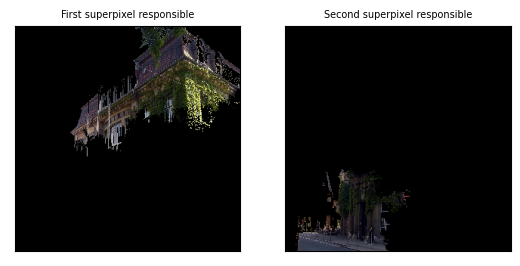

In [ ]:
# image 3 first probability

images_top_cof3_1 = train_linear_model(index3,prob_1_container3,similarity_score3)

fig, (ax3_1, ax3_2) = plt.subplots(1, 2)
ax3_1.imshow(super_pixels3[(images_top_cof3_1[0])])
ax3_1.set_title('First superpixel responsible',fontsize=7)
ax3_1.set_xticks([])
ax3_1.set_yticks([])
ax3_2.imshow(super_pixels3[(images_top_cof3_1[1])])
ax3_2.set_title('Second superpixel responsible',fontsize=7)
ax3_2.set_xticks([])
ax3_2.set_yticks([])

[]

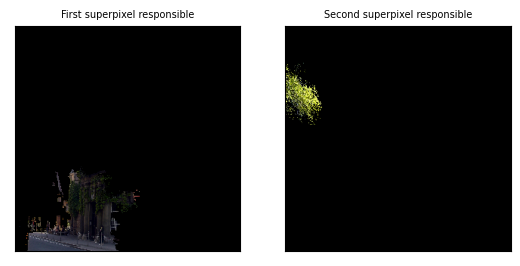

In [ ]:
# image 3 Second probability

images_top_cof3_2 = train_linear_model(index3,prob_2_container3,similarity_score3)

fig, (axi3_1, axi3_2) = plt.subplots(1, 2)
axi3_1.imshow(super_pixels3[(images_top_cof3_2[0])])
axi3_1.set_title('First superpixel responsible',fontsize=7)
axi3_1.set_xticks([])
axi3_1.set_yticks([])
axi3_2.imshow(super_pixels3[(images_top_cof3_2[1])])
axi3_2.set_title('Second superpixel responsible',fontsize=7)
axi3_2.set_xticks([])
axi3_2.set_yticks([])